In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import clip
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Dataset**

In [2]:
from VQA_Datasetv2 import VQA_Dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

dataset = VQA_Dataset()
dataset.load_all(preprocess, length=200, device=device)

#Testing dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

for element in tqdm(dataloader, desc="Testing"):
    id = element['image_id']
    if id == 26216:
        print(element["question"])#, "question: ", i['question_tokens'], "answer: ", i['answer_tokens'])

Testing: 100%|██████████| 200/200 [00:00<00:00, 5466.24it/s]

['Is the man tell the girl to slide down?']
["Is the man old enough to be the girl's grandfather?"]
['What color is the slide?']


**Test-train split**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


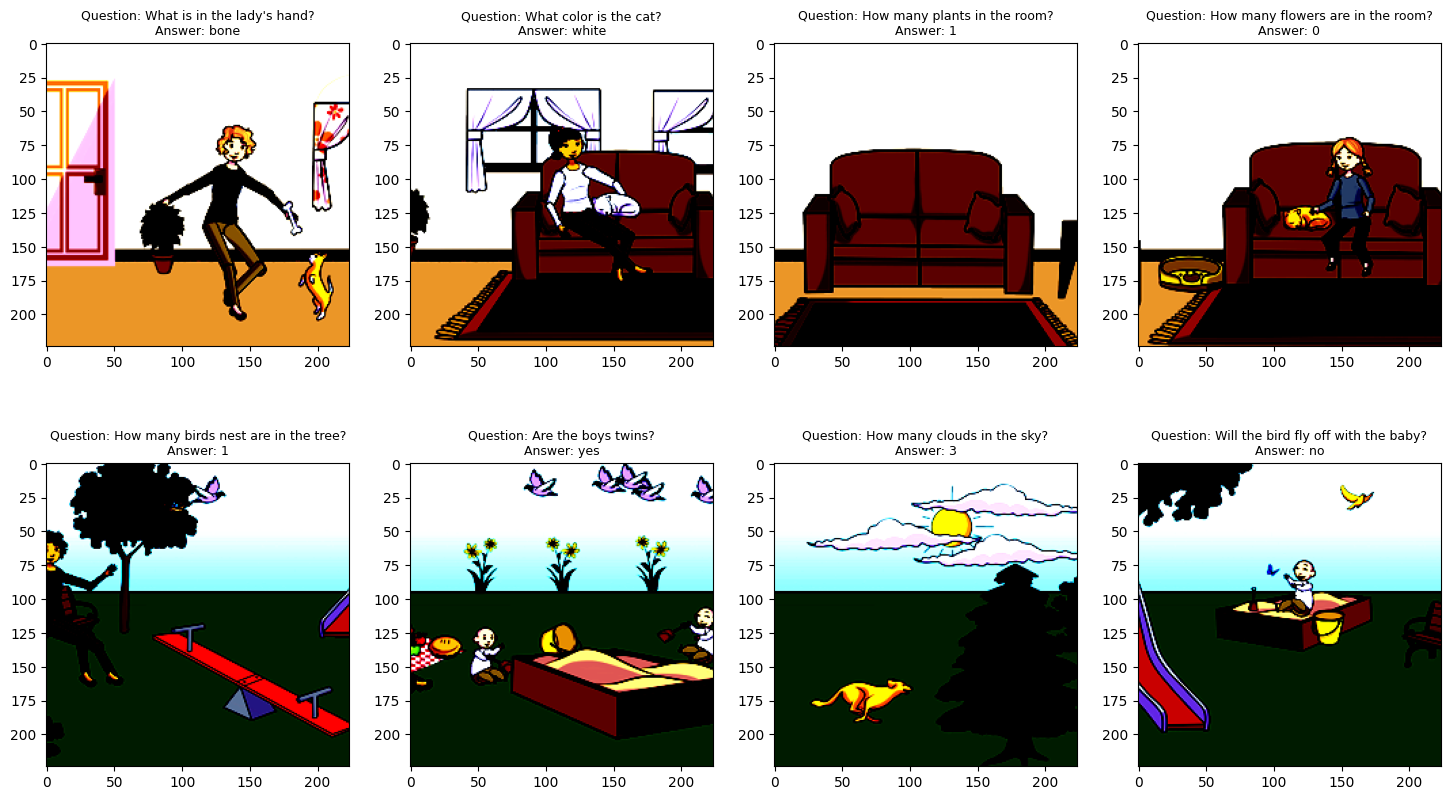

In [6]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

train_size = int(len(dataset)*0.8)
test_size = int(len(dataset))-train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size=8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#Checking data
fig=plt.figure(0, (18, 10))
for element in train_dataloader:
    for i in range(batch_size):
        ax = fig.add_subplot(2,int(batch_size/2),i+1)
        ax.imshow(np.transpose(element["image"][i][0].cpu(), (1, 2, 0))) #Converting to matplotlib format
        ax.set_title("Question: "+str(element["question"][i])+"\nAnswer: "+str(element["correct_answer_text"][i]), fontsize=9)
    break